In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts
from matplotlib import rcParams,font_manager
from matplotlib.ticker import FormatStrFormatter
import pickle

%load_ext autoreload
%autoreload 2

In [3]:
rcParams['figure.figsize'] = (6,6) #figure size in inches
rcParams['font.family'] = "sans-serif" 
rcParams['font.weight'] = "roman" 
rcParams['font.style'] = "normal" # not 100% sure what this does but it was recommended
rcParams['font.size'] = 32 # not 100% sure what this does but it was recommended
rcParams['pdf.fonttype'] = 42
rcParams['axes.linewidth'] = 2 #thickness of the border
rcParams['xtick.major.width'] = rcParams['axes.linewidth'] # make sure line widths are consistent
rcParams['ytick.major.width'] = rcParams['axes.linewidth']
rcParams['axes.spines.right'] = False #hides right border
rcParams['axes.spines.top'] = False #hides top
rcParams['legend.frameon'] = False #hides box around the legend
rcParams['legend.fontsize'] = 18 #font size in pt
rcParams['axes.labelsize'] = 32 
rcParams['xtick.labelsize'] = 24
rcParams['ytick.labelsize'] = rcParams['xtick.labelsize']
rcParams['lines.linewidth'] = 3
rcParams['xtick.major.size'] = 5
rcParams['lines.markersize'] = 16
rcParams['ytick.major.size'] = rcParams['xtick.major.size'] 

In [4]:
direc = 'C:/Users/svo/Google Drive/Bas Games/Analysis/'
fig_direc = 'C:/Users/svo/Google Drive/Bas Games/Figures/'

In [5]:
def ave_across_splits(p):
    return np.nanmean(np.reshape(p,[-1,5]),axis=1)

def get_mean(fname):
    try:
        x = np.loadtxt(fname)
        if len(x.shape)>1:
            return np.mean(x[:,np.nonzero(np.prod(x>0,axis=0))[0]])
        else:
            return np.mean(x)
    except OSError:
        print('File not found: ' + fname)
        return np.nan
    
def get_data(fname):
    try:
        x = np.loadtxt(fname)
        if len(x.shape)>1:
            return np.mean(x[:,np.nonzero(np.prod(x>0,axis=0))[0]],axis=1)
        else:
            print(fname,x.shape)
            return x
    except OSError:
        print('File not found: ' + fname)
        return np.full([200,],fill_value=np.nan)

In [6]:
models=['final','final_nonoise','final_nodelta','final_noprune','final_notree','final_noact','final_no3',
        'final_no2conn','final_nocenter','final_no4','final_no2unc',
        'final_optweights','final_mcts_myopic','final_drop_tile','final_fixed_iters',
        'final_fixed_depth','final_fixed_branch','final_weight_hvd','final_drop_hvd',
        'final_triangle','final_drop_type','final_opp']

model_names = ['Main','No value noise','No feature drop','No pruning','No tree','No active scaling',
               'No 3-in-a-row','No connected 2-in-a-row','No center','No 4-in-a-row',
               'No unconnected 2-in-a-row','Optimal weights','Monte Carlo Tree Search',
               'Tile dropping','Fixed iterations','Fixed depth','Fixed branching',
               'Orientation-dependent weights','Orientation-dependent dropping','Triangle',
               'Type-dependent dropping','Opponent scaling']

model_colors = ['black'] + ['#A30006']*10 + ['#025D8C']*6 + ['#519548']*5 + ['gray']

data_sets = ['hvh','gen','eye','learn1','learn2','learn3','tai1','tai2']


In [7]:
list(zip(models,model_names))

[('final', 'Main'),
 ('final_nonoise', 'No value noise'),
 ('final_nodelta', 'No feature drop'),
 ('final_noprune', 'No pruning'),
 ('final_notree', 'No tree'),
 ('final_noact', 'No active scaling'),
 ('final_no3', 'No 3-in-a-row'),
 ('final_no2conn', 'No connected 2-in-a-row'),
 ('final_nocenter', 'No center'),
 ('final_no4', 'No 4-in-a-row'),
 ('final_no2unc', 'No unconnected 2-in-a-row'),
 ('final_optweights', 'Optimal weights'),
 ('final_mcts_myopic', 'Monte Carlo Tree Search'),
 ('final_drop_tile', 'Tile dropping'),
 ('final_fixed_iters', 'Fixed iterations'),
 ('final_fixed_depth', 'Fixed depth'),
 ('final_fixed_branch', 'Fixed branching'),
 ('final_weight_hvd', 'Orientation-dependent weights'),
 ('final_drop_hvd', 'Orientation-dependent dropping'),
 ('final_triangle', 'Triangle'),
 ('final_drop_type', 'Type-dependent dropping'),
 ('final_opp', 'Opponent scaling')]

In [90]:
with open(direc + 'loglik_all_pickled.txt','rb') as f:
    loglik_all = pickle.load(f)

In [64]:
#loglik_all = [[get_data(direc + 'Loglik/loglik_' + d + '_' + m + '.txt')
#               for m in models] for d in data_sets]
#loglik_all = [np.array(L) for L in loglik_all[:3]] + [np.hstack([np.array(L) for L in loglik_all[3:6]])] + [np.hstack([np.array(L) for L in loglik_all[6:]])]


C:/Users/svo/Google Drive/Bas Games/Analysis/Loglik/loglik_hvh_final_opp.txt (200,)


In [89]:
with open(direc + 'loglik_all_pickled.txt','wb') as f:
    pickle.dump(loglik_all,file=f)

In [91]:
def plot_model_comparison(loglik,xrange,figname): 
    
    loglik_main = np.mean(loglik[0,:])
    loglik_diff = np.mean(loglik,axis=1) - loglik_main
    loglik_sem = np.std(loglik - loglik[0,:][None,:],axis=1)/np.sqrt(loglik.shape[1])

    fig, ax = plt.subplots(figsize=(12,9))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))

    xmin = xrange[0]
    ax.set_ylim([0.5,len(model_names)+0.5])
    ax.set_yticks(range(len(model_names),0,-1))
    ax.set_yticklabels(model_names,fontsize=20)
    ax.set_xticks([-2.4,-2.2,-2,-1.8])
    ax.barh(range(len(model_names),0,-1), -loglik_diff, xerr = loglik_sem, height = 0.7, align='center',
         color=model_colors, ecolor='black', left=-loglik_main)
    ax.plot(-loglik_main,len(model_names),'.k')
    ax.axvline(x=-loglik_main, color='black')
    ax.axhline(y=21.5, color='black', linestyle = 'dashed')
    ax.axhline(y=16.5, color='black', linestyle = 'dashed')
    ax.axhline(y=11.5, color='black', linestyle = 'dashed')
    ax.axhline(y=5.5, color='black', linestyle = 'dashed')
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(True)
    ax.set_xlim(xrange)
    ax.text(xmin,19, 'Lesions: features', ha ='left', va='center',fontsize=24)
    ax.text(xmin,14, 'Lesions: components', ha ='left', va='center',fontsize=24)
    ax.text(xmin,8.5, 'Modifications', ha ='left', va='center',fontsize=24)
    ax.text(xmin,2.5, 'Extensions', ha ='left', va='center',fontsize=24)
    ax.set_xlabel('Log-likelihood per move')
    fig.subplots_adjust(bottom=0.12,top=0.96,right=0.6,left=0.05)
    fig.savefig(fig_direc + figname)
    plt.show()


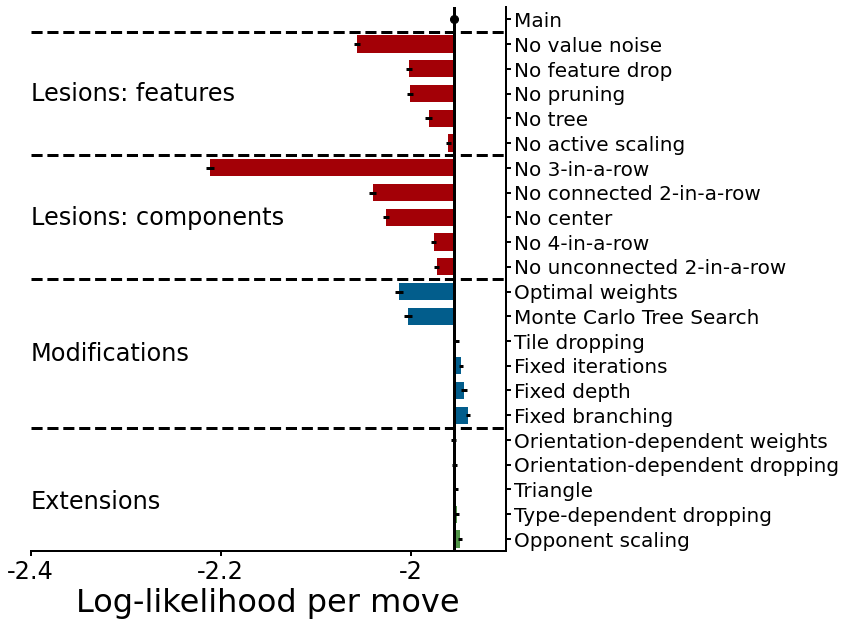

In [92]:
plot_model_comparison(np.hstack(loglik_all),[-2.4,-1.9],'supp_fig_3A.pdf')

In [93]:
def get_alpha_fdr(alpha,allps):
    return allps[np.nonzero(allps > np.arange(1,len(allps)+1)/len(allps)*alpha)[0][0]]

t = [sts.ttest_rel(np.hstack(loglik_all)[0,:],np.hstack(loglik_all)[i,:]) for i in range(np.hstack(loglik_all).shape[0])]

In [94]:
print(get_alpha_fdr(0.05,[tt.pvalue for tt in t]))

0.43679428321841807


In [95]:
t

[Ttest_relResult(statistic=nan, pvalue=nan),
 Ttest_relResult(statistic=-29.986623063287386, pvalue=4.766666326883019e-158),
 Ttest_relResult(statistic=-15.571003122890636, pvalue=4.1445414846168384e-51),
 Ttest_relResult(statistic=-15.175019380240837, pvalue=8.69923835138745e-49),
 Ttest_relResult(statistic=-7.264424139565831, pvalue=5.753443292454445e-13),
 Ttest_relResult(statistic=-2.71525337464452, pvalue=0.006691597782574368),
 Ttest_relResult(statistic=-56.88310811427194, pvalue=0.0),
 Ttest_relResult(statistic=-25.15466469098856, pvalue=1.8896877532472836e-118),
 Ttest_relResult(statistic=-20.696708902164886, pvalue=8.834197594513058e-85),
 Ttest_relResult(statistic=-8.366749597760702, pvalue=1.245389630152811e-16),
 Ttest_relResult(statistic=-7.330666117906075, pvalue=3.571683380498561e-13),
 Ttest_relResult(statistic=-14.625747309416672, pvalue=1.218962470003032e-45),
 Ttest_relResult(statistic=-13.052780184224307, pvalue=3.95873347873122e-37),
 Ttest_relResult(statistic=0.77

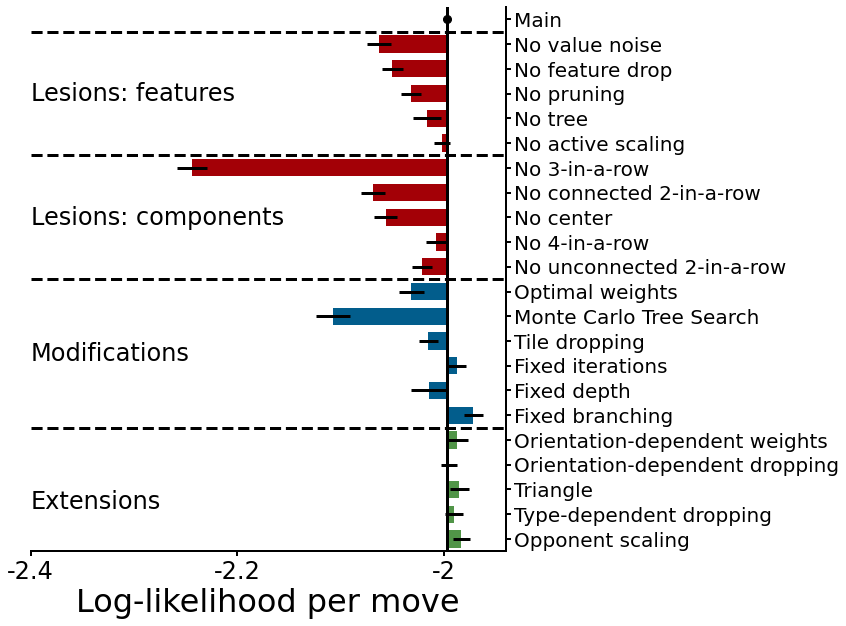

In [96]:
plot_model_comparison(loglik_all[0],[-2.4,-1.94],'supp_fig_3B.pdf')

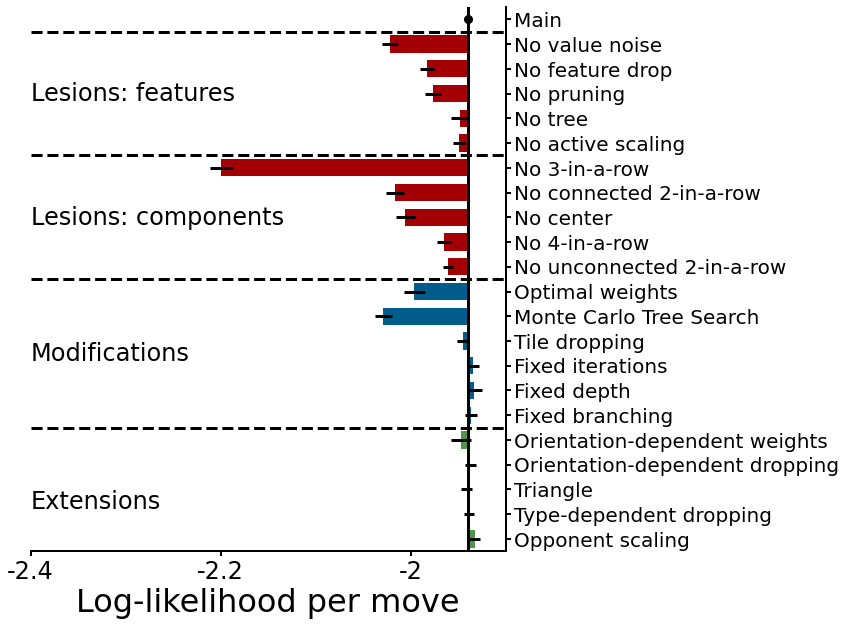

In [97]:
plot_model_comparison(loglik_all[1],[-2.4,-1.9],'supp_fig_3C.pdf')

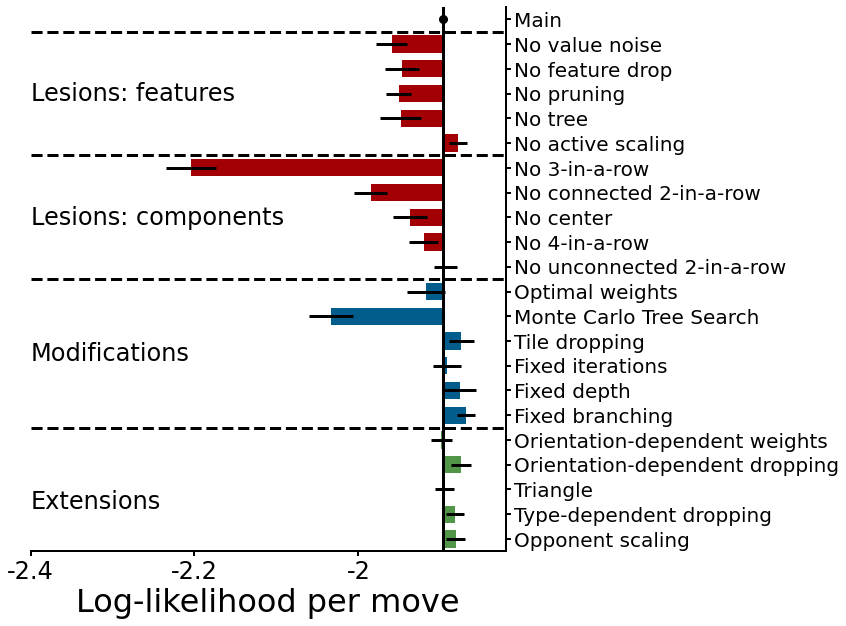

In [98]:
plot_model_comparison(loglik_all[2],[-2.4,-1.82],'supp_fig_3D.pdf')

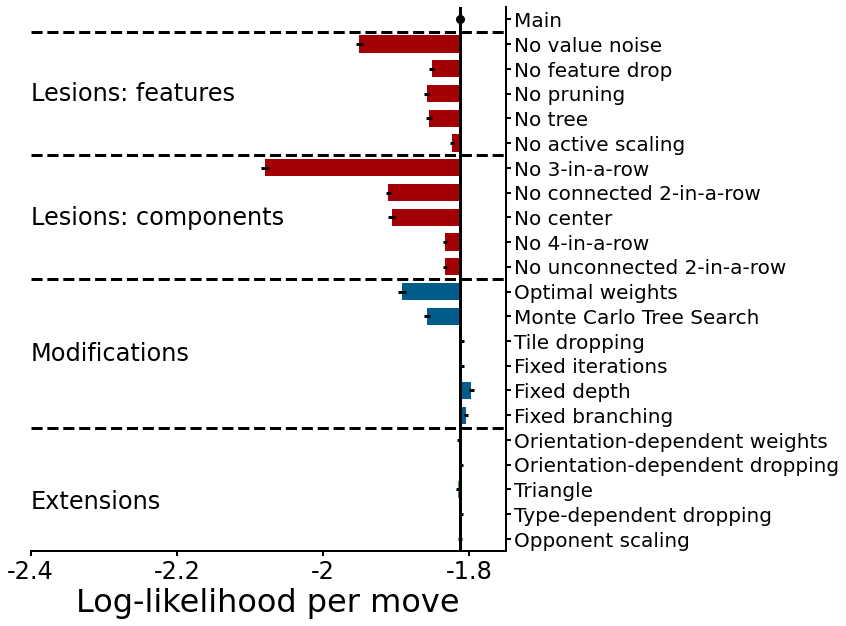

In [99]:
plot_model_comparison(loglik_all[3],[-2.4,-1.75],'supp_fig_3E.pdf')

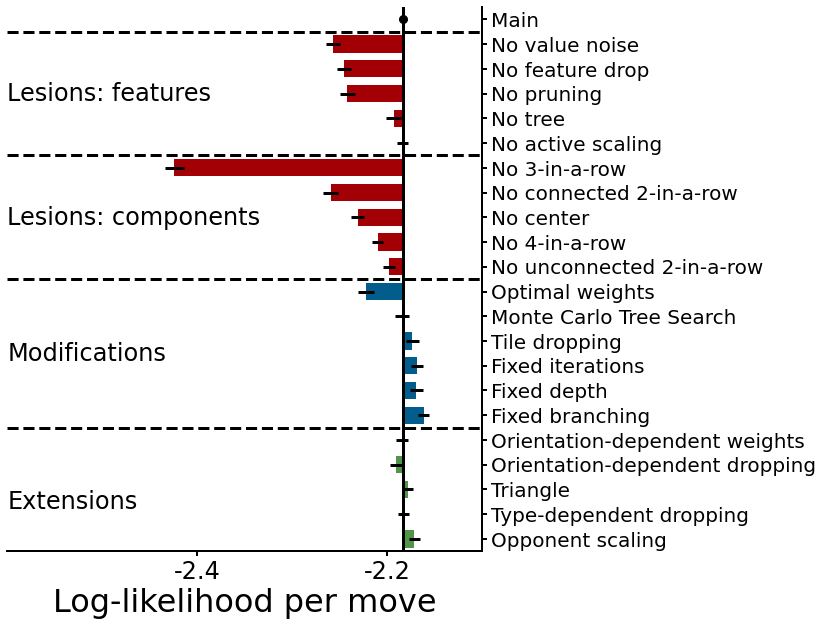

In [100]:
plot_model_comparison(loglik_all[4],[-2.6,-2.1],'supp_fig_3F.pdf')

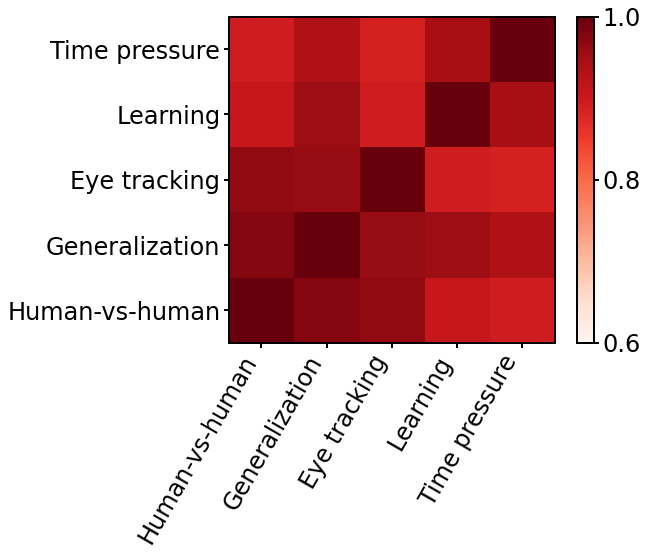

0.9316377464498009 0.01014411312121102


In [101]:
A = np.array([np.mean(L,axis=1) for L in loglik_all])
c = np.corrcoef(A)
data_names= ['Human-vs-human','Generalization','Eye tracking','Learning','Time pressure']

fig, ax = plt.subplots(figsize=(8,6))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.spines['right'].set_visible(True)
ax.spines['top'].set_visible(True)

cax = ax.imshow(c,interpolation='nearest',origin='lower',cmap='Reds',vmin=0.6,vmax=1)

ax.set_xticks(range(len(data_names)))
ax.set_yticks(range(len(data_names)))
ax.set_yticklabels(data_names)
ax.set_xticklabels(data_names,rotation=60,ha='right')
ax.set_xlim([-0.5,4.5])
ax.set_ylim([-0.5,4.5])
cbar = fig.colorbar(cax, ticks=[0.6, 0.8, 1])
#fig.savefig(fig_direc + 'supp_figure_model_comp_corr_A.pdf')
plt.show()

print(np.mean(c[np.triu_indices(5,1)]),np.std(c[np.triu_indices(5,1)])/np.sqrt(10))